# Lab 1

## Part 2: Neural Machine Translation in the wild
In the second part of the homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.
* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* or just fine-tunning BERT)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__
Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# ! pip  instalschtext

# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [3]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [4]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token  = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token  = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [5]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [6]:
print(f"Number of training examples:   {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples:    {len(test_data .examples)}")

Number of training examples:   40000
Number of validation examples: 2500
Number of testing examples:    7500


In [7]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [8]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9253
Unique tokens in target (en) vocabulary: 6706


Here are tokens from original (RU) corpus:

In [9]:
SRC.vocab.itos[::1000]

['<unk>',
 'еду',
 'арены',
 'кост',
 'chalet',
 'фос',
 'marta',
 'финского',
 'диснейленд',
 'таррагона']

And from target (EN) corpus:

In [10]:
TRG.vocab.itos[::1000]

['<unk>', 'tumble', 'groves', 'cristobal', 'mahal', 'southeast', 'maximus']

And here is example from train dataset:

In [11]:
print(vars(train_data.examples[9]))

{'trg': ['this', 'holiday', 'home', 'is', '60', 'km', 'from', 'kastrup', 'airport', '.'], 'src': ['расстояние', 'от', 'дома', 'для', 'отпуска', 'до', 'аэропорта', 'каструп', 'составляет', '60', 'км', '.']}


Let's check the length distributions:

Length distribution in Train data


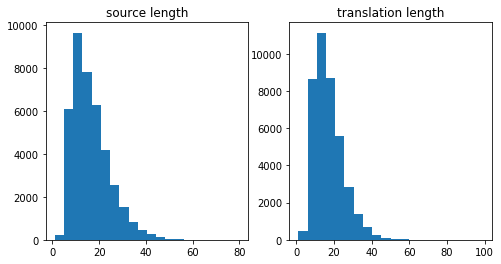

In [12]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


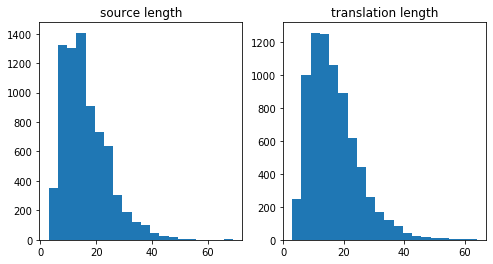

In [13]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [14]:
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')

In [15]:
device

device(type='cuda', index=4)

In [16]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [17]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 39x128 (GPU 4)]
	[.src]:[torch.cuda.LongTensor of size 42x128 (GPU 4)]
torch.Size([42, 128]) torch.Size([39, 128])


### Model

In [18]:
class SelfAttention (nn.Module):
    def __init__(self, emb_dim, query_key_size, value_size):
        super().__init__()
    
        self.emb_dim        = emb_dim
        self.query_key_size = query_key_size
        self.value_size     = value_size
        
        self.emb_to_query = nn.Linear(emb_dim, query_key_size)
        self.emb_to_key   = nn.Linear(emb_dim, query_key_size)
        self.emb_to_value = nn.Linear(emb_dim, value_size)
        
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        # X : [src sent len, batch size, emb dim]
        x = x.permute((1, 0, 2))
        
        
        # X : [batch size, src sent len, emb dim]
        
        query = self.emb_to_query(x)
        key   = self.emb_to_key  (x)
        value = self.emb_to_value(x)
        
        # key or query : [batch size, src sent len, key/query size]
        weighted_values = []
        for i in range(query.shape[1]):
            #loc query = query [:, i, :]
            weights = torch.sum(
                          key * query[:, i, :].unsqueeze(1),
                          dim=2)
            weights /= (self.query_key_size ** 0.5)
            weights = self.softmax(weights)
            
            # weights : [batch size, sent len]
            # key or value : [batch size, src sent len, key/value size]
            
            loc_value = torch.sum(
                            value * weights.unsqueeze(2),
                            dim=1)
            # loc_value : [batch size, value_size]
            
            weighted_values.append(loc_value.unsqueeze(1))
        
        return torch.cat(weighted_values, dim=1)       

In [19]:
class EncoderSelfAtt (nn.Module):
    def __init__(self, input_dim, emb_dim, query_key_size, n_attentions, hid_dim):
        super().__init__()
        assert (emb_dim % n_attentions == 0)
        
        self.input_dim  = input_dim
        self.emb_dim    = emb_dim
        self.value_size = int(emb_dim / n_attentions)
        self.hid_dim    = hid_dim
        self.n_layers   = 1
        
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim =emb_dim
        )
        
        self.self_attentions = [SelfAttention(
                                    emb_dim,
                                    query_key_size,
                                    self.value_size).to(device)
                                for i in range(n_attentions)]    
        
        self.feed_forward = nn.Linear(emb_dim, hid_dim)
        
        self.ff_to_encoded = nn.Sequential()
        self.conv = nn.Conv1d(
                        in_channels=hid_dim,
                        out_channels=hid_dim,
                        kernel_size=3,
                        padding=1)
        self.relu = nn.ReLU()
        self.avg_pool = nn.AdaptiveAvgPool1d(output_size=1)
        
    def forward(self, x):
        embedded = self.embedding(x)
        
        residuals = [attention(embedded) for attention in self.self_attentions]
        residuals = torch.cat(residuals, dim=2)
        
        # embedded  : [src sent len, batch size, emb dim]
        # residuals : [batch size, src sent len, emb dim]
          
        embedded = embedded.permute((1, 0, 2))
        embedded += residuals
        
        embedded = self.feed_forward(embedded)
        
        embedded = embedded.permute((0, 2, 1))
        embedded = self.relu(self.conv(embedded))
        embedded = self.avg_pool(embedded)
        
        return embedded.permute(2, 0, 1)  

In [20]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=emb_dim
        )
        
        self.rnn = nn.GRU(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
        
        self.out = nn.Linear(
            in_features=hid_dim,
            out_features=output_dim
        )
        
        self.dropout = nn.Dropout(p=dropout)# <YOUR CODE HERE>
        
    def forward(self, input, hidden):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        # Compute an embedding from the input data and apply dropout to it
        embedded = self.dropout(self.embedding(input))# <YOUR CODE HERE>
        
        #embedded = [1, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)
        # <YOUR CODE HERE>
        
        
        #output = [sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]\
        
        #sent len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        
#         print ("Decoder embedded", embedded.shape)
#         print ("Decoder hidden"  , hidden  .shape)
                
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden


In [21]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
#         assert encoder.n_layers == decoder.n_layers, \
#             "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src sent len, batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        # Again, now batch is the first dimention instead of zero
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
#         print ("Seq2Seq, src :", src.shape)
        hidden = self.encoder(src)
#         print ("Seq2Seq, hidden(src) :", hidden.shape)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, max_len):
            
#             print ("Seq2Seq, input  :", input.shape)
#             print ("Seq2Seq, hidden :", hidden.shape)
            
            output, hidden = self.decoder(input, hidden)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)
        
        return outputs


In [22]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

QUERY_KEY_SIZE = 64
N_ATTENTIOS    = 4

# enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
enc = EncoderSelfAtt(INPUT_DIM, ENC_EMB_DIM, QUERY_KEY_SIZE, N_ATTENTIOS, HID_DIM).to(device)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)


/home/romakail/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [23]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): EncoderSelfAtt(
    (embedding): Embedding(9253, 256)
    (feed_forward): Linear(in_features=256, out_features=512, bias=True)
    (ff_to_encoded): Sequential()
    (conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (avg_pool): AdaptiveAvgPool1d(output_size=1)
  )
  (decoder): Decoder(
    (embedding): Embedding(6706, 256)
    (rnn): GRU(256, 512, dropout=0.5)
    (out): Linear(in_features=512, out_features=6706, bias=True)
    (dropout): Dropout(p=0.5)
  )
)

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,626,930 trainable parameters


In [25]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [26]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
#         print ("Src :", src.shape)
#         print ("Trg :", trg.shape)
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [27]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [28]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [29]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

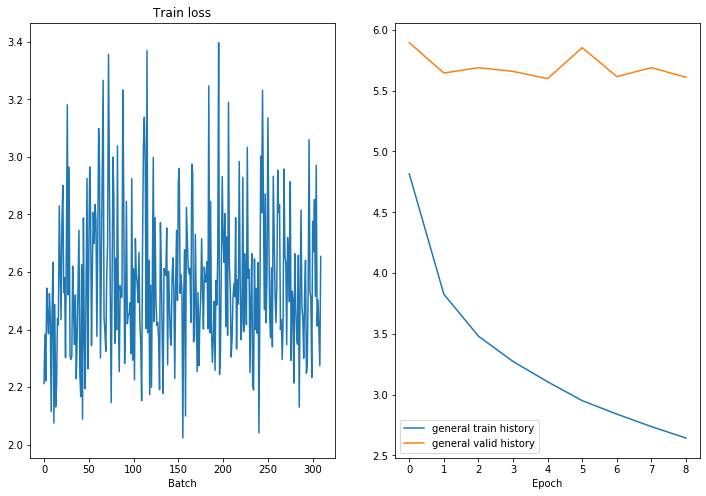

Epoch: 10 | Time: 2m 13s
	Train Loss: 2.563 | Train PPL:  12.976
	 Val. Loss: 5.894 |  Val. PPL: 362.940
CPU times: user 4h 36min 35s, sys: 43min 3s, total: 5h 19min 38s
Wall time: 23min 6s


In [30]:
%%time
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [38]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [39]:
batch = next(iter(test_iterator))

In [40]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: the property offers free parking .
Generated: free private parking free private parking free private parking free private parking free private parking free private

Original: the property offers free parking .
Generated: free private parking free private parking free private parking free private parking free private parking free private



In [41]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [42]:
import tqdm

In [43]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:05,  7.50it/s]


In [44]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

9.662090784699732

Baseline solution BLEU score is quite low. Try to achieve at least __25__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points